In [ ]:
import os
os.environ['OPENAI_API_KEY']='sk-...'

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langchain.chat_models import init_chat_model

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = init_chat_model("openai:gpt-4.1")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [3]:
from langgraph.graph import START, END

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

How does the LangGraph look like right?

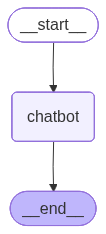

In [4]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [5]:
graph.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | chatbot |   
 +---------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


In [6]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

stream_graph_updates('what is the capital of Argentina?')

Assistant: The capital of Argentina is **Buenos Aires**.


Right now, this is just a simple chatbot.

Let's introduce tools

In [7]:
from langchain_community.tools.wikidata.tool import WikidataAPIWrapper, WikidataQueryRun

wikidata_tool = WikidataQueryRun(api_wrapper=WikidataAPIWrapper())

print(wikidata_tool.run("Alan Turing"))

Result Q7251:
Label: Alan Turing
Description: English computer scientist (1912–1954)
Aliases: Alan M. Turing, Alan Mathieson Turing, Turing, Alan Mathison Turing
instance of: human
country of citizenship: United Kingdom
occupation: computer scientist, mathematician, university teacher, cryptographer, logician, statistician, marathon runner, artificial intelligence researcher
sex or gender: male
date of birth: 1912-06-23
date of death: 1954-06-07
sport: athletics
place of birth: Maida Vale, Warrington Lodge
educated at: King's College, Princeton University, Sherborne School, Hazlehurst Community Primary School
employer: Victoria University of Manchester, Government Communications Headquarters, University of Cambridge, National Physical Laboratory
place of death: Wilmslow
field of work: cryptanalysis, computer science, mathematics, logic, cryptography
cause of death: cyanide poisoning
notable work: On Computable Numbers, with an Application to the Entscheidungsproblem, Computing Machiner

In [8]:
from langchain_core.messages import ToolMessage
import json

class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}
    
    def __call__(self, inputs: dict):
        print('calling basic tool node...')
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs")
        outputs = []
        for tool_call in message.tool_calls:
            print(f'tool {tool_call} being processed...')
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tools = [wikidata_tool]
tool_node = BasicToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

Finally, let's plug tools into our LangGraph

In [9]:
def route_tools(state: State):
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError("No messages found in inputs")
    
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    
    return END

In [10]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")

graph = graph_builder.compile()

Let's see how our graph looks now

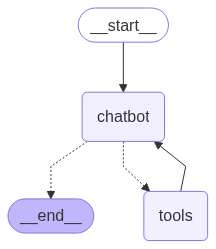

In [11]:
Image(graph.get_graph().draw_mermaid_png())

In [12]:
graph.get_graph().print_ascii()

        +-----------+         
        | __start__ |         
        +-----------+         
               *              
               *              
               *              
          +---------+         
          | chatbot |         
          +---------+         
          .         .         
        ..           ..       
       .               .      
+---------+         +-------+ 
| __end__ |         | tools | 
+---------+         +-------+ 


In [13]:
stream_graph_updates("Alan Turing")

Assistant: 
calling basic tool node...
tool {'name': 'Wikidata', 'args': {'query': 'Alan Turing'}, 'id': 'call_VScUe6LuZiMiy44l0Ue2zJ0L', 'type': 'tool_call'} being processed...


Assistant: "Result Q7251:\nLabel: Alan Turing\nDescription: English computer scientist (1912\u20131954)\nAliases: Alan M. Turing, Alan Mathieson Turing, Turing, Alan Mathison Turing\ninstance of: human\ncountry of citizenship: United Kingdom\noccupation: computer scientist, mathematician, university teacher, cryptographer, logician, statistician, marathon runner, artificial intelligence researcher\nsex or gender: male\ndate of birth: 1912-06-23\ndate of death: 1954-06-07\nsport: athletics\nplace of birth: Maida Vale, Warrington Lodge\neducated at: King's College, Princeton University, Sherborne School, Hazlehurst Community Primary School\nemployer: Victoria University of Manchester, Government Communications Headquarters, University of Cambridge, National Physical Laboratory\nplace of death: Wilmslow\nfield of work: cryptanalysis, computer science, mathematics, logic, cryptography\ncause of death: cyanide poisoning\nnotable work: On Computable Numbers, with an Application to the Entsch

That’s awesome - we can now use tools in LangGraph!

But do we always need to write the graph ourselves?

No — LangGraph makes it easier by providing a prebuilt graph for agents + tools: create_react_agent!

In [14]:
from langgraph_cognee import add_tool, search_tool
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
        "openai:gpt-4o-mini",
        tools=[
            add_tool,
            search_tool,
        ],
    )
agent.step_timeout = None


2025-09-25T15:03:14.941730 [info     ] Deleted old log file: /Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/logs/2025-09-25_14-43-55.log [cognee.shared.logging_utils]

2025-09-25T15:03:15.201438 [info     ] Logging initialized            [cognee.shared.logging_utils] cognee_version=0.2.4 database_path=/Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases graph_database_name= os_info='Darwin 24.5.0 (Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:43 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8132)' python_version=3.12.7 relational_config=cognee_db structlog_version=25.4.0 vector_config=lancedb

2025-09-25T15:03:15.201822 [info     ] Database storage: /Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases [cognee.shared.logging_utils]


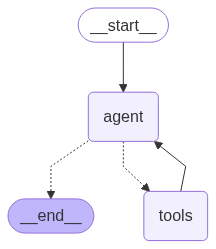

In [15]:
Image(agent.get_graph().draw_mermaid_png())

In [16]:
import cognee

os.environ['LLM_API_KEY']=os.environ['OPENAI_API_KEY']

await cognee.prune.prune_data()
await cognee.prune.prune_system(metadata=True)


2025-09-25T15:03:16.806236 [info     ] Deleted Kuzu database files at /Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases/cognee_graph_kuzu [cognee.shared.logging_utils]

2025-09-25T15:03:19.380131 [info     ] Database deleted successfully. [cognee.shared.logging_utils]


In [17]:
from langchain_core.messages import HumanMessage

response = agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Meditech Solutions". Company is in the healthcare industry. Start date is Jan 2023 and end date is Dec 2025. Contract value is £1.2M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "QuantumSoft". Company is in the technology industry. Start date is Aug 2024 and end date is Aug 2028. Contract value is £5.5M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Orion Retail Group". Company is in the retail industry. Start date is Mar 2024 and end date is Mar 2026. Contract value is £850K.
            """
            ),
        ],
    }
)


print("=== FIRST RESPONSE ===")
print(response["messages"][-1].content)


Adding data to cognee: Contract with QuantumSoft, technology industry, start date: Aug 2024, end date: Aug 2028, contract value: £5.5M.

Adding data to cognee: Contract with Meditech Solutions, healthcare industry, start date: Jan 2023, end date: Dec 2025, contract value: £1.2M.

Adding data to cognee: Contract with Orion Retail Group, retail industry, start date: Mar 2024, end date: Mar 2026, contract value: £850K.

2025-09-25T15:03:26.578687 [info     ] Model not found in LiteLLM's model_cost. [cognee.shared.logging_utils]

Langfuse client is disabled since no public_key was provided as a parameter or environment variable 'LANGFUSE_PUBLIC_KEY'. See our docs: https://langfuse.com/docs/sdk/python/low-level-sdk#initialize-client


User 8517ec6f-4b20-4c92-b864-ebffa36dd247 has registered.



EmbeddingRateLimiter initialized: enabled=False, requests_limit=60, interval_seconds=60

2025-09-25T15:03:27.940132 [info     ] Pipeline run started: `4799ca47-da24-5cd3-a807-9dcb1c89f679` [run_tasks_with_telemetry()]

2025-09-25T15:03:27.940642 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:03:27.941122 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-09-25T15:03:27.951814 [info     ] Registered loader: pypdf_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-09-25T15:03:27.952138 [info     ] Registered loader: text_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-09-25T15:03:27.952398 [info     ] Registered loader: image_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-09-25T15:03:27.952761 [info     ] Registered loader: audio_loader [cognee.infrastructure.loaders.LoaderEngine]

2025-09-25T15:03:27.953099 [info     ] Registered loader: unstructured_loader [cognee.infrastructure.loaders.L

=== FIRST RESPONSE ===
The contracts have been successfully stored:

1. **Meditech Solutions**: Healthcare industry, Start date: Jan 2023, End date: Dec 2025, Contract value: £1.2M.
2. **QuantumSoft**: Technology industry, Start date: Aug 2024, End date: Aug 2028, Contract value: £5.5M.
3. **Orion Retail Group**: Retail industry, Start date: Mar 2024, End date: Mar 2026, Contract value: £850K.

If you need any further information or actions, feel free to ask!


Cool!

Let's also add some data into our knowledge graph (secretly from LangGraph)

In [18]:
agent.step_timeout = None

data_dir = os.path.join(os.getcwd(), "data")
for filename in os.listdir(data_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(data_dir, filename)
        with open(file_path, "r") as f:
            content = f.read()
            await cognee.add(content)
await cognee.cognify()


2025-09-25T15:03:46.050979 [info     ] Pipeline run started: `4799ca47-da24-5cd3-a807-9dcb1c89f679` [run_tasks_with_telemetry()]

2025-09-25T15:03:46.051532 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:03:46.051896 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-09-25T15:03:46.062021 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]

2025-09-25T15:03:46.062295 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:03:46.062542 [info     ] Pipeline run completed: `4799ca47-da24-5cd3-a807-9dcb1c89f679` [run_tasks_with_telemetry()]

2025-09-25T15:03:46.065810 [info     ] Model not found in LiteLLM's model_cost. [cognee.shared.logging_utils]

2025-09-25T15:03:46.066103 [info     ] Ontology file 'None' not found. No owl ontology will be attached to the graph. [OntologyAdapter]

2025-09-25T15:03:46.076578 [info     ] Pipeline run started: `a121b50e-b0df-55a

{UUID('c3d2c2ad-81a4-5694-97f0-ef28b301c4b9'): PipelineRunCompleted(status='PipelineRunCompleted', pipeline_run_id=UUID('1727a72d-1d15-5d91-bcb5-6b53c01f806d'), dataset_id=UUID('c3d2c2ad-81a4-5694-97f0-ef28b301c4b9'), dataset_name='main_dataset', payload=None, data_ingestion_info=[{'run_info': PipelineRunCompleted(status='PipelineRunCompleted', pipeline_run_id=UUID('1727a72d-1d15-5d91-bcb5-6b53c01f806d'), dataset_id=UUID('c3d2c2ad-81a4-5694-97f0-ef28b301c4b9'), dataset_name='main_dataset', payload=None, data_ingestion_info=None), 'data_id': UUID('254a6d27-fde7-557d-975a-6d195b721abc')}, {'run_info': PipelineRunCompleted(status='PipelineRunCompleted', pipeline_run_id=UUID('1727a72d-1d15-5d91-bcb5-6b53c01f806d'), dataset_id=UUID('c3d2c2ad-81a4-5694-97f0-ef28b301c4b9'), dataset_name='main_dataset', payload=None, data_ingestion_info=None), 'data_id': UUID('41003377-2bc9-54b8-96be-15d6b4462136')}, {'run_info': PipelineRunAlreadyCompleted(status='PipelineRunAlreadyCompleted', pipeline_run_id

Let's see how it looks after adding new data

In [19]:
import webbrowser

async def generate_graph(open_browser = True):
    destination_file_path = os.path.join(os.getcwd(), "graph_visualization.html")

    await cognee.visualize_graph(destination_file_path)

    if open_browser:
        url = "file://" + os.path.abspath(destination_file_path)
        webbrowser.open(url)

await generate_graph()


2025-09-25T15:05:03.862413 [info     ] Graph visualization saved as /Users/daulet/Desktop/dev/langgraph-cognee/examples/graph_visualization.html [cognee.shared.logging_utils]

2025-09-25T15:05:03.863351 [info     ] The HTML file has been stored at path: /Users/daulet/Desktop/dev/langgraph-cognee/examples/graph_visualization.html [cognee.shared.logging_utils]


Now, let's create a fresh new agent, to demonstrate that no state is carried over into a new agent

I.e. - it knows nothing we sent to previous agent

In [20]:
# Create a fresh agent instance to avoid memory interference
fresh_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)
agent.step_timeout = None

response = fresh_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="I need to research our contract portfolio. Can you search for any contracts we have with companies in the healthcare industry? Please use the search functionality to find this information."
            ),
        ],
    }
)
print("\n=== SECOND RESPONSE ===")
print(response["messages"][-1].content)


Searching cognee for: contracts with companies in the healthcare industry

2025-09-25T15:05:07.559585 [info     ] Graph projection completed: 52 nodes, 94 edges in 0.00s [CogneeGraph]

2025-09-25T15:05:07.867069 [info     ] Vector collection retrieval completed: Retrieved distances from 6 collections in 0.03s [cognee.shared.logging_utils]

2025-09-25T15:05:07.870041 [info     ] Model not found in LiteLLM's model_cost. [cognee.shared.logging_utils]

Async operation completed successfully

Search results: ['We have signed contracts with the following companies in the healthcare industry:\n\n1. **HealthBridge Systems** - Contract value: £2.4M, Start date: Feb 2023, End date: Jan 2026.\n2. **NovaCare Diagnostics** - Contract value: £1.6M, Start date: May 2024, End date: Apr 2027.\n3. **Meditech Solutions** - Contract value: £1.2M, Start date: Jan 2023, End date: Dec 2025.']



=== SECOND RESPONSE ===
Here are the contracts we have with companies in the healthcare industry:

1. **HealthBridge Systems**
   - Contract Value: £2.4M
   - Start Date: February 2023
   - End Date: January 2026

2. **NovaCare Diagnostics**
   - Contract Value: £1.6M
   - Start Date: May 2024
   - End Date: April 2027

3. **Meditech Solutions**
   - Contract Value: £1.2M
   - Start Date: January 2023
   - End Date: December 2025


Great!

These inputs to LangGraph and by extension Cognee look like they could benefit from additional metadata.

In [21]:
await cognee.prune.prune_data()
await cognee.prune.prune_system(metadata=True)


2025-09-25T15:05:16.150612 [info     ] Deleted Kuzu database files at /Users/daulet/Desktop/dev/langgraph-cognee/.venv/lib/python3.12/site-packages/cognee/.cognee_system/databases/cognee_graph_kuzu [cognee.shared.logging_utils]

2025-09-25T15:05:18.183210 [info     ] Database deleted successfully. [cognee.shared.logging_utils]


In [22]:
from langgraph_cognee import get_sessionized_cognee_tools

add_tool, search_tool = get_sessionized_cognee_tools('cognee-test-user-1f5b133c-a98d-4448-9876-c31b8ba9b6e1')

super_fresh_agent = create_react_agent(
    "openai:gpt-4o-mini",
    tools=[
        add_tool,
        search_tool,
    ],
)

super_fresh_agent.step_timeout = None

response = super_fresh_agent.invoke(
    {
        "messages": [
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Guardian Insurance Ltd". Company is in the insurance industry. Start date is Feb 2023 and end date is Feb 2026. Contract value is £1.8M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Pioneer Assurance Group". Company is in the insurance industry. Start date is Oct 2024 and end date is Oct 2029. Contract value is £4.2M.
            """
            ),
            HumanMessage(
                content="""
                We have signed a contract with the following company: "Finovate Systems". Company is in the fintech industry. Start date is May 2024 and end date is May 2027. Contract value is £2.3M.
            """
            ),

        ],
    }
)

print("=== FIRST RESPONSE ===")
print(response["messages"][-1].content)


Using tool add_tool with user_id: cognee-test-user-1f5b133c-a98d-4448-9876-c31b8ba9b6e1

Adding data to cognee: Company: Pioneer Assurance Group, Industry: Insurance, Start Date: Oct 2024, End Date: Oct 2029, Contract Value: £4.2M

Using tool add_tool with user_id: cognee-test-user-1f5b133c-a98d-4448-9876-c31b8ba9b6e1

Using tool add_tool with user_id: cognee-test-user-1f5b133c-a98d-4448-9876-c31b8ba9b6e1

Adding data to cognee: Company: Guardian Insurance Ltd, Industry: Insurance, Start Date: Feb 2023, End Date: Feb 2026, Contract Value: £1.8M

Adding data to cognee: Company: Finovate Systems, Industry: Fintech, Start Date: May 2024, End Date: May 2027, Contract Value: £2.3M

2025-09-25T15:05:22.635830 [info     ] Pipeline run started: `8e0002c8-e97e-581f-884f-d5d147bd24e7` [run_tasks_with_telemetry()]

2025-09-25T15:05:22.636202 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:05:22.636533 [info     ] Coroutine task started: `ingest_data

User 830b256b-ed0a-40b5-895d-d4679c859785 has registered.



2025-09-25T15:05:32.883766 [info     ] No close match found for 'company' in category 'classes' [OntologyAdapter]

2025-09-25T15:05:32.885188 [info     ] No close match found for 'pioneer assurance group' in category 'individuals' [OntologyAdapter]

2025-09-25T15:05:32.885849 [info     ] No close match found for 'industry' in category 'classes' [OntologyAdapter]

2025-09-25T15:05:32.886437 [info     ] No close match found for 'insurance' in category 'individuals' [OntologyAdapter]

2025-09-25T15:05:32.886973 [info     ] No close match found for 'date' in category 'classes' [OntologyAdapter]

2025-09-25T15:05:32.887546 [info     ] No close match found for 'october 2024' in category 'individuals' [OntologyAdapter]

2025-09-25T15:05:32.888064 [info     ] No close match found for 'october 2029' in category 'individuals' [OntologyAdapter]

2025-09-25T15:05:32.888529 [info     ] No close match found for 'contract value' in category 'classes' [OntologyAdapter]

2025-09-25T15:05:32.888985 [in

=== FIRST RESPONSE ===
The contracts with the following companies have been successfully stored:

1. **Guardian Insurance Ltd**
   - Industry: Insurance
   - Start Date: Feb 2023
   - End Date: Feb 2026
   - Contract Value: £1.8M

2. **Pioneer Assurance Group**
   - Industry: Insurance
   - Start Date: Oct 2024
   - End Date: Oct 2029
   - Contract Value: £4.2M

3. **Finovate Systems**
   - Industry: Fintech
   - Start Date: May 2024
   - End Date: May 2027
   - Contract Value: £2.3M


In [23]:
await cognee.add('hm')
await cognee.cognify()
await generate_graph()


2025-09-25T15:05:45.758338 [info     ] Pipeline run started: `8e0002c8-e97e-581f-884f-d5d147bd24e7` [run_tasks_with_telemetry()]

2025-09-25T15:05:45.758706 [info     ] Coroutine task started: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:05:45.759062 [info     ] Coroutine task started: `ingest_data` [run_tasks_base]

2025-09-25T15:05:45.770684 [info     ] Coroutine task completed: `ingest_data` [run_tasks_base]

2025-09-25T15:05:45.771500 [info     ] Coroutine task completed: `resolve_data_directories` [run_tasks_base]

2025-09-25T15:05:45.771811 [info     ] Pipeline run completed: `8e0002c8-e97e-581f-884f-d5d147bd24e7` [run_tasks_with_telemetry()]

2025-09-25T15:05:45.777104 [info     ] Model not found in LiteLLM's model_cost. [cognee.shared.logging_utils]

2025-09-25T15:05:45.777470 [info     ] Ontology file 'None' not found. No owl ontology will be attached to the graph. [OntologyAdapter]

2025-09-25T15:05:45.789344 [info     ] Pipeline run started: `7e960748-1c6a-582